### Social Media Virality using Networks

In [1]:
# import
import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib.colors

### Initializing the model

In [20]:
num_nodes = 50
online_probability = 0.6

network = nx.watts_strogatz_graph(num_nodes, k=4, p=0.2)

def initialize():

  # initialize all nodes to have not seen or shared the post
  for node in network.nodes():
    network.nodes[node]['seen_post'] = 0
    network.nodes[node]['shared_post'] = 0

    # initialize about 80% of the network to be online
    if random.random() < online_probability:
      network.nodes[node]['online'] = 1
    else:
      network.nodes[node]['online'] = 0

  # select initial node ot share post
  initial_sharer = random.choice(list(network.nodes()))
  network.nodes[initial_sharer]['shared_post'] = 1
  network.nodes[initial_sharer]['seen_post'] = 1
  network.nodes[initial_sharer]['online'] = 1

  return network

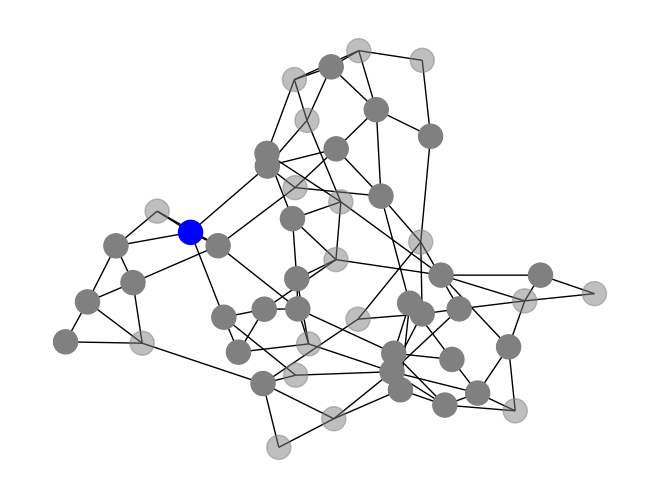

In [21]:
# Observe the initial network
def observe():
  node_colors = []
  for node in network.nodes():
    if network.nodes[node]['shared_post'] == 1:
      color = 'blue'
    elif network.nodes[node]['seen_post'] == 1:
      color = 'green'
    else:
      color = 'gray'

    alpha = 1.0 if network.nodes[node]['online'] == 1 else 0.5
    rgba_color = matplotlib.colors.to_rgba(color, alpha)
    node_colors.append(rgba_color)

  nx.draw(network, node_color=node_colors, with_labels=False)
  plt.show()

initialize()
observe()

### Observing the model

In [ ]:
def observe():
